In [59]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import re
import chardet

In [60]:
# データベース接続
conn = sqlite3.connect('jalan.db')
cur = conn.cursor()


In [61]:
# スクレイピング対象URL
url = "https://www.jalan.net/110000/LRG_110500/?stayYear=2025&stayMonth=1&stayDay=22&stayCount=1&roomCount=1&adultNum=2&ypFlg=1&kenCd=110000&screenId=UWW1380&roomCrack=200000&lrgCd=110500&distCd=01&rootCd=04"

# データ取得
response = requests.get(url)
# エンコーディングを自動検出
detected_encoding = chardet.detect(response.content)['encoding']

# BeautifulSoupで解析、エンコーディングを指定
soup = BeautifulSoup(response.content, "html.parser", from_encoding=detected_encoding)

# 旅館情報を含む要素を取得
inns = soup.find_all("div", class_="p-yadoCassette__summary")

for inn in inns:
    try:
        # 旅館名の取得
        name = inn.find("h2", class_="p-searchResultItem__facilityName").text.strip()

        # 評価の取得
        rating_element = inn.find("span", class_="p-searchResultItem__summaryaverage-num")
        rating = float(rating_element.text) if rating_element else None

        # 口コミ件数の取得
        comment_count_element = inn.find("span", class_="p-searchResultItem__summarykuchikomi__totalNumber")
        if comment_count_element:
            comment_count_text = comment_count_element.text
            comment_count_match = re.search(r'\d+', comment_count_text)
            comment_count = int(comment_count_match.group(0)) if comment_count_match else None
        else:
            comment_count = None

        # 価格帯の取得
        price_element = inn.find("span", class_="p-searchResultItem__lowestPriceValue")
        if price_element:
            price_text = price_element.text.replace('円～', '').replace(',', '')
            price = int(price_text) if price_text.isdigit() else None
        else:
            price = None
        
        price_range = None
        if price is not None:
            if price <= 10000:
                price_range = "安い"
            elif price <= 20000:
                price_range = "普通"
            else:
                price_range = "高い"

        # データベースに挿入
        cur.execute("INSERT INTO inns (name, rating, comment_count, price_range) VALUES (?, ?, ?, ?)", (name, rating, comment_count, price_range))

    except AttributeError:
        print("Error: Could not find element. Skipping...")
        print(inn)


In [62]:
# コミット
conn.commit()

# データベース接続を閉じる
conn.close()

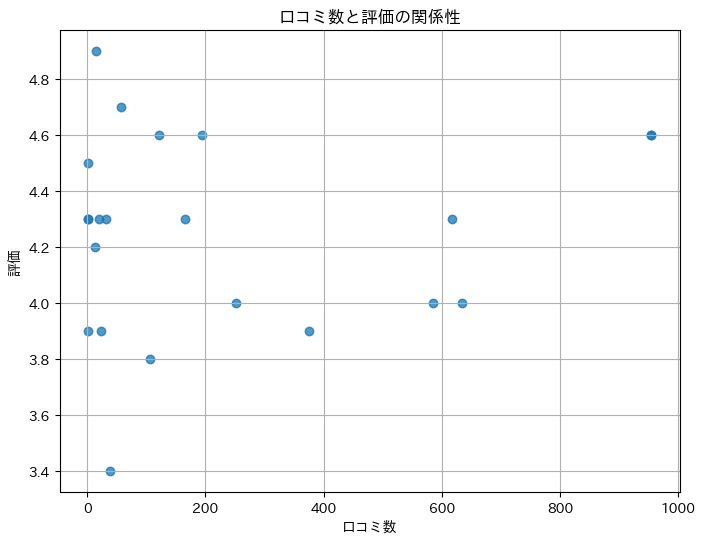

口コミ数と評価の相関係数: 0.12


In [63]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

# データベース接続
conn = sqlite3.connect('jalan.db') 
cur = conn.cursor()

# データ取得
cur.execute("SELECT rating, comment_count FROM inns")
data = cur.fetchall()

# リストに変換
# Noneのデータは除外
ratings = [row[0] for row in data if row[0] is not None] 
comment_counts = [row[1] for row in data if row[1] is not None] 

# 散布図を作成
plt.figure(figsize=(8, 6))
plt.scatter(comment_counts, ratings, alpha=0.5)
plt.title('口コミ数と評価の関係性')
plt.xlabel('口コミ数')
plt.ylabel('評価')
plt.grid(True)
plt.show()

# 相関係数を計算
correlation = np.corrcoef(comment_counts, ratings)[0, 1]
print(f"口コミ数と評価の相関係数: {correlation:.2f}")

# データベース接続終了
conn.close()

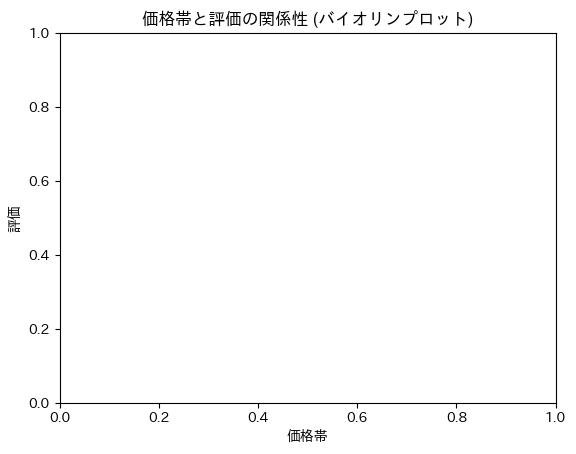

In [64]:
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# データベース接続
conn = sqlite3.connect('jalan.db')
cur = conn.cursor()

# データの取得
cur.execute("SELECT price_range, rating FROM inns WHERE rating IS NOT NULL AND price_range IS NOT NULL")
data = cur.fetchall()

# データフレームに変換
import pandas as pd
df = pd.DataFrame(data, columns=['price_range', 'rating'])

# バイオリンプロットの作成
sns.violinplot(x='price_range', y='rating', data=df)
plt.xlabel('価格帯')
plt.ylabel('評価')
plt.title('価格帯と評価の関係性 (バイオリンプロット)')
plt.show()

# データベース接続終了
conn.close()